<img src="../../thumbnail.png" width=500 alt="Kerchunk Logo"></img>

# Multi-File Datasets with Kerchunk

## Overview

This notebook is intends to build off of the [Kerchunk Basics notebook](./kerchunk_basics.ipynb).

In this tutorial we will:
- Create a list of input paths for a collection of NetCDF files stored on the cloud.
- Iterate through our file input list and create `Kerchunk` reference `.jsons` for each file.
- Combine the reference `.jsons` into a single combined dataset reference with the rechunker class, `MultiZarrToZarr`
- Learn how to read the combined dataset  using [`Xarray`](https://docs.xarray.dev/en/stable/) and [`fsspec`](https://filesystem-spec.readthedocs.io/en/latest/).


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Kerchunk Basics](./kerchunk_basics.ipynb) | Required | Basic features |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Recommended | IO |

- **Time to learn**: 60 minutes
---

## Imports
In our imports block we are using similar imports to the [Kerchunk Basics Tutorial](./kerchunk_basics.ipynb), with a few libraries added.
- `fsspec` for reading and writing to remote file systems
- `ujson` for writing `Kerchunk` reference files as `.json`
- `Xarray` for visualizing and examining our datasets
- `Kerchunk's` `SingleHdf5ToZarr` and `MultiZarrToZarr` methods. 
- `tqdm` for timing cell progress



In [8]:
import fsspec
import ujson
import xarray as xr
from kerchunk.combine import MultiZarrToZarr
from kerchunk.hdf import SingleHdf5ToZarr
from tqdm import tqdm

### Create a File Pattern from a list of  input NetCDF files

Below we will create a list of input files we want `Kerchunk` to index. In the [Kerchunk Basics Tutorial](./kerchunk_basics.ipynb), we looked at a single file of climate downscaled data over Southern Alaska. In this example, we will build off of that work and use `Kercunk` to combine multiple NetCDF files of this dataset into a virtual dataset that can be read as if it were a `Zarr` store.

Specifically, in the cell below, we use `fsspec` to create a `s3` filesystem to read the `NetCDF` files and a local file system to write our reference files to. Note: Alternatively, you can write to a cloud filesystem instead of a local one.
After that, we use the `fsspec` **fs_read** `s3` filesystem's *glob* method to create a list of files matching a file pattern. We supply the base url of `s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/`, which is pointing to an `AWS` public bucket, for daily rcp85 ccsm downscaled data for the year 2060. After this base url, we tacked on *`*`*, which acts as a wildcard for all the files in the directory. We should expect 365 daily `NetCDF` files.

Finally, we are appending the string `s3://` to the list of return files. This will ensure the list of files we get back are `s3` urls and can be read by `Kerchunk`.



In [9]:
# Initiate fsspec filesystems for reading and writing
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)
fs_write = fsspec.filesystem("")

# Retrieve list of available days in archive for the year 2060.
files_paths = fs_read.glob("s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/*")

# Here we prepend the prefix 's3://', which points to AWS.
file_pattern = sorted(["s3://" + f for f in files_paths])

#### As a quick check, it looks like we have a list 365 file paths, which should be a year of downscaled climte data. 

In [10]:
print(f"{len(file_pattern)} file paths were retrieved.")

365 file paths were retrieved.


### Optional: If you want to examine one NetCDF files before creating the `Kerchunk` index, try uncommenting this code snippet below.

In [11]:
## Note: Optional piece of code to view one of the NetCDF files using Xarray as fsspec.

# import s3fs

# fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
# with fs.open(file_pattern[0]) as fileObj:
#     ds = xr.open_dataset(fileObj)
#     print(ds)
#     print(ds.nbytes / 1e9)

## Create `Kerchunk` References for every file in the `File_Pattern` list

Now that we have a list of NetCDF files, we can use `Kerchunk` to create reference files for each one of these. To do this, we will iterate through each file and create a reference `.json`. To speed this process up, you could use `Dask` to parallelize this.

### Note: To speed next section up, uncomment the next cell.  This will reduce the # of input files from 365 to 7, going from a year's worth of data, to a weeks worth of data.


In [12]:
### OPTIONAL SPEEDUP: DEFAULT IS OFF ###

file_pattern = file_pattern[0:7]

### Define kwargs for `fsspec`
In the cell below, we are creating a dictionary of `kwargs` to pass to `fsspec` and the `s3` filesystem. Details on this can be found in the [Kerchunk Basics Tutorial](./kerchunk_basics.ipynb) in the **```(Define kwargs for fsspec)```** section.

In [13]:
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")
output_dir = "./"

In the cell below, we are mirroring some of the functionality from the previous tutorial. 
First we are defining a function named: `generate_json_reference`. 
This function:
- Uses an `fsspec` `s3` filesystem to read in a `NetCDF` from a given url.
- Generates a `Kerchunk` index using the `SingleHdf5ToZarr` `Kerchunk` method.
- Creates a simplified filename using some string slicing.
- Uses the local filesytem created with `fsspec` to write the `Kerchunk` index to a `.json` reference file.

Below the `generate_json_reference` function we created, we have a simple `for` loop that iterates through our list of `NetCDF` file urls and passes them to our `generate_json_reference` function, which appends the name of each `.json` reference file to a list named **output_files**.


In [14]:
# Use Kerchunk's `SingleHdf5ToZarr` method to create a `Kerchunk` index from a NetCDF file.
def generate_json_reference(u, output_dir: str):
    with fs_read.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)
        fname = u.split("/")[-1].strip(".nc")
        outf = f"{fname}.json"
        with open(outf, "wb") as f:
            f.write(ujson.dumps(h5chunks.translate()).encode())
        return outf


# Iterate through filelist to generate Kerchunked files. Good use for `Dask`
output_files = []
for fil in tqdm(file_pattern):
    outf = generate_json_reference(fil, output_dir)
    output_files.append(outf)

100%|██████████| 7/7 [22:48<00:00, 195.52s/it]


#### Here we can view the generated list of output `Kerchunk` reference files

In [15]:
output_files

['WRFDS_2060-01-01.json',
 'WRFDS_2060-01-02.json',
 'WRFDS_2060-01-03.json',
 'WRFDS_2060-01-04.json',
 'WRFDS_2060-01-05.json',
 'WRFDS_2060-01-06.json',
 'WRFDS_2060-01-07.json']

## Combine `.json` `Kerchunk` reference files and write a combined `Kerchunk` reference dataset.

After we have generated a `Kerchunk` reference file for each `NetCDF` file, we can combine these into a single virtual dataset using `Kerchunk's` `MultiZarrToZarr` method. 
In our example below we are passing in our list of reference files (`output_files`), along with `concat_dims` and `identical_dims`.
- `concat_dims` should be a list of the name(s) of the dimensions(s) that you want to concatenate along. In our example, our input files were single time steps. Because of this, we will concatenate along the `Time` axes. 
- `identical_dims` are variables that are shared across all the input files. They should not vary across the files.

After using `MultiZarrToZarr` to combine the reference files, we will call `.translate()` to store this combined refernce dataset into memory. Note: by passing `filename` to `.translate()`, you can write the combined `Kerchunk` multi-file dataset to disk as a `.json` file. 

ex: ```mzz.translate(filename='combined_reference.json')```


In [16]:
# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(
    output_files,
    concat_dims=["Time"],
    identical_dims=["south_north", "west_east", "interp_levels", "soil_layers_stag"],
)


multi_kerchunk = mzz.translate()

/Users/nrhagen/opt/anaconda3/envs/install/envs/kerc/lib/python3.10/site-packages/kerchunk/combine.py:250: UserWarning: Concatenated coordinate 'Time' contains less than expectednumber of values across the datasets: [0]
  warnings.warn(


## Write combined kerchunk index for future use
If we want to keep the combined reference information in memory as well as write the file to `.json`, we can run the code snippet below.

In [17]:
# Write kerchunk .json record
output_fname = "combined_kerchunk.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

## Using the output

Now that we have built a virtual dataset using `Kerchunk`, we can read all of those original `NetCDF` files as if they were a single `Zarr` dataset. 


**Since we saved the combined reference `.json` file, this work doesn't have to be repeated for anyone else to use this dataset. All they need is to pass the combined refernece file to `Xarray` and it is as if they had a `Zarr` dataset!** 

### Open combined `Kerchunk` dataset with `fsspec` and `Xarray`

Below we are using the result of the `MultiZarrtoZarr` method as input to a `fsspec` filesystem. `Fsspec` can read this `Kerchunk` reference file as if it were a `Zarr` dataset.

- `fsspec.filesystem` creates a remote filesystem using the combined reference, along with arguments to specify which type of filesystem it's reading from `s3` as well as some kwargs for `s3`, such as `remote_options`.
- We can pass the `fsspec.filesystems` mapper object to `Xarray` to open the combined reference recipe as if it were a `Zarr` dataset. 


In [18]:
# open dataset as zarr object using fsspec reference file system and Xarray
fs = fsspec.filesystem(
    "reference", fo=multi_kerchunk, remote_protocol="s3", remote_options={"anon": True}
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False))
ds

/Users/nrhagen/opt/anaconda3/envs/install/envs/kerc/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/nrhagen/opt/anaconda3/envs/install/envs/kerc/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:        (Time: 1, south_north: 250, west_east: 320,
                    interp_levels: 9, soil_layers_stag: 4)
Coordinates:
  * Time           (Time) datetime64[ns] NaT
    XLAT           (Time, south_north, west_east) float32 ...
    XLONG          (Time, south_north, west_east) float32 ...
  * interp_levels  (interp_levels) float32 100.0 200.0 300.0 ... 925.0 1e+03
Dimensions without coordinates: south_north, west_east, soil_layers_stag
Data variables: (12/37)
    ACSNOW         (Time, south_north, west_east) float32 ...
    ALBEDO         (Time, south_north, west_east) float32 ...
    CLDFRA         (Time, interp_levels, south_north, west_east) float32 ...
    GHT            (Time, interp_levels, south_north, west_east) float32 ...
    HFX            (Time, south_north, west_east) float32 ...
    LH             (Time, south_north, west_east) float32 ...
    ...             ...
    U              (Time, interp_levels, south_north, west_east) float32 ...
    U10            (Time, south_north, west_east) float32 ...
    V              (Time, interp_levels, south_north, west_east) float32 ...
    V10            (Time, south_north, west_east) float32 ...
    lat            (Time, south_north, west_east) float32 ...
    lon            (Time, south_north, west_east) float32 ...
Attributes:
    contact:  rtladerjr@alaska.edu
    data:     Downscaled CCSM4
    date:     Mon Oct 21 11:37:23 AKDT 2019
    format:   version 2
    info:     Alaska CASC

## Plot a slice of the dataset

Here we are using `Xarray` to select a single time slice of the dataset and plot a map of snow cover over South East Alaska.

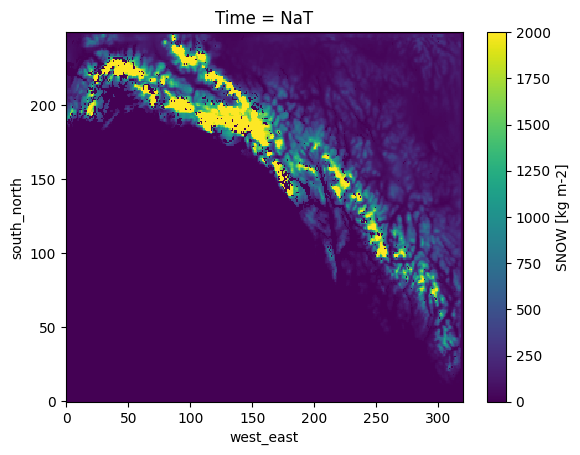

In [19]:
ds.isel(Time=0).SNOW.plot()